In [1]:
import numpy as np
import pandas as pd

import pyspark as ps
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

import matplotlib.pyplot as plt

Initialize Spark Context

In [2]:
spark = ps.sql.SparkSession.builder \
            .master("local[2]") \
            .appName("matrix factorization") \
            .getOrCreate()

sc = spark.sparkContext

Read in data

In [3]:
ratings = spark.read \
    .options(inferSchema=True, delimiter=',', header=True) \
    .csv('../data/movies/ratings.csv')

In [4]:
ratings = ratings.drop('timestamp')

In [5]:
ratings.take(2)

[Row(userId=1, movieId=31, rating=2.5),
 Row(userId=1, movieId=1029, rating=3.0)]

In [26]:
pandas_df = ratings.toPandas()

AttributeError: 'RDD' object has no attribute 'toPandas'

# Try training basic ALS model
Reference: https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html

In [6]:
ratings = ratings.rdd

In [7]:
# Build the recommendation model using Alternating Least Squares
rank = 10
numIterations = 10
model = ALS.train(ratings, rank, numIterations)

# Evaluate the model on training data
testdata = ratings.map(lambda p: (p[0], p[1]))
predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.2755213950798869


In [8]:
print(f"RMSE = {np.sqrt(MSE)}")

RMSE = 0.5249013193733532


## See if the predictions make sense

In [9]:
user_ratings = np.array(ratings.map(lambda r: r[2]).collect())
print("Sample actual user ratings:", user_ratings[:10])

Sample actual user ratings: [2.5 3.  3.  2.  4.  2.  2.  2.  3.5 2. ]


In [10]:
user_predictions = np.array(predictions.sortBy(lambda x: x[0]).map(lambda x: x[1]).collect())
print("Sample user predictions:", user_predictions[:10].round(1))

Sample user predictions: [2.4 2.8 2.7 2.2 3.8 2.5 2.2 2.2 3.2 2. ]


In [11]:
predicted_minus_actual = (user_predictions - user_ratings).round(1)
print("Sample difference between predicted and actual:", predicted_minus_actual[:10])

Sample difference between predicted and actual: [-0.1 -0.2 -0.3  0.2 -0.2  0.5  0.2  0.2 -0.3 -0. ]


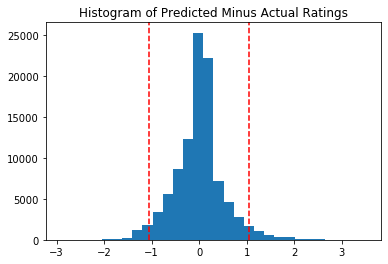

In [22]:
_ = plt.hist(sorted(predicted_minus_actual), bins=30)
_ = plt.title("Histogram of Predicted Minus Actual Ratings")
plt.axvline(np.mean(predicted_minus_actual) + 2 * np.sqrt(MSE), c = 'r', linestyle = '--')
plt.axvline(np.mean(predicted_minus_actual) - 2 * np.sqrt(MSE), c = 'r', linestyle = '--')

In [14]:
np.mean(predicted_minus_actual)+ np.sqrt(MSE)

0.5233453816108636

In [25]:
np.std(predicted_minus_actual)

0.5256442969192819

## Grid search

In [31]:
from sklearn import svm, datasets
from spark_sklearn import GridSearchCV
iris = datasets.load_iris()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC(gamma='auto')
clf = GridSearchCV(sc, svr, parameters)
clf.fit(iris.data, iris.target)

TypeError: __init__() got an unexpected keyword argument 'fit_params'

In [42]:


# Build the recommendation model using Alternating Least Squares
parameters = {'rank':[5, 10, 15], numIterations:[3, 6]}

MSEs = []

ranks = [5,10,15,20,25]

for r in ranks:
    numIterations = 10
    model = ALS.train(ratings, r, numIterations)

    # Evaluate the model on training data
    testdata = ratings.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    #print("Mean Squared Error = " + str(MSE))
    MSEs.append(MSE)
    
for r, m in zip(ranks, MSEs):
    print('rank: {0}, MSE: {1:.2f}'.format(r, m))

rank: 5, MSE: 0.41
rank: 10, MSE: 0.27
rank: 15, MSE: 0.19
rank: 20, MSE: 0.14
rank: 25, MSE: 0.10


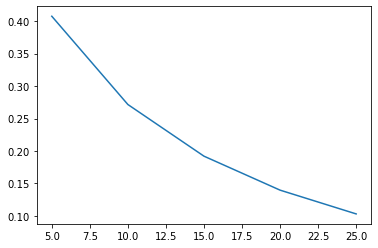

In [44]:
plt.plot(ranks, MSEs);

In [51]:
iters = [2,4,6,8,10]

MSEsi = []

for i in iters:
    rank = 10
    model = ALS.train(ratings, rank, i)
    
    # Evaluate the model on training data
    testdata = ratings.map(lambda p: (p[0], p[1]))
    predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), r[2]))
    ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
    #print("Mean Squared Error = " + str(MSE))
    MSEsi.append(MSE)
    
for i, m in zip(iters, MSEsi):
    print('num iterations: {0}, MSE: {1:.2f}'.format(i, m))

num iterations: 2, MSE: 0.54
num iterations: 4, MSE: 0.33
num iterations: 6, MSE: 0.29
num iterations: 8, MSE: 0.28
num iterations: 10, MSE: 0.27


In [50]:
MSEsi

[0.2749271735678938]

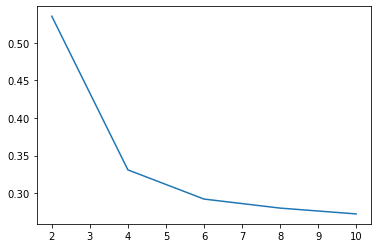

In [52]:
plt.plot(iters, MSEsi);